In [5]:
import seaborn as sns
sns.set_context('paper')

### Load Database

In [6]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [7]:
db = DB('earthfury-alliance')

### Flipping Analysis
Assume you purchase at a given percentile price 'buy_pctile' of an item and flip it for a 15% profit.  By examining how minBidprice fluctuates over time, determine how many times you could perform this flip 'num_flips'.  Calulate numFlips for values of P from 1 to 100.  Determine the optimal 'buy_pctile' that maximizes num_flips and look up the corresponding minBidPrice.

In [57]:
def num_flips(item, buy_pctile, profit):
    df = db.get_df(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPctile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    
    return count

# def flips_by_pctiles(item, profit):
#     return [ (i/100, num_flips(item, i/100, profit)) for i in range(0,100)]

# def best_flip_pctile_at_fixed_profit(item, profit):
#     return max(flips_by_pctiles(item, profit), key=lambda x:x[1])

# def flip_by_profit_at_best_pctile(item):
#     # for all profits, 5 to 100%
#     return [(i/100, best_flip_pctile_at_fixed_profit(item, i/100)) for i in range(5,100)]

# def best_flip(item):
#     return max(flip_by_profit_at_best_pctile(item, key=lambda x:x[1]))

def get_minBuyout_at_pctile(item, pctile):
    arr = db.get_df(item)['minBuyout'].to_list()
    return np.percentile(arr, pctile*100)


In [54]:
%%time
num_flips(3818, 0.22, .15)

Wall time: 988 µs


15

In [73]:
%%time
item = 3818
steps = np.linspace(0,.99,100)

results = []
for buy_pctile in steps:
    for profit in steps:
        results.append((buy_pctile, 
                        profit, 
                        num_flips(item, buy_pctile, profit)
                       ))

df = pd.DataFrame(results, columns = ['buy_pctile', 'profit','num_flips'])
df['buy_price'] = df['buy_pctile'].apply(lambda x: get_minBuyout_at_pctile(item, x))
df['net'] = df['buy_price'] * df['num_flips'] * (df['profit']-.05)
df[df['net'] == df['net'].max()]

Wall time: 8.9 s


,buy_pctile,profit,num_flips,buy_price,net
1337,0.13,0.37,10,54.0,172.8
1437,0.14,0.37,10,54.0,172.8


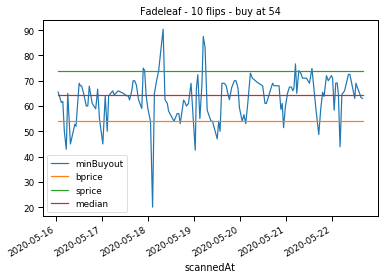

In [76]:
nflips = 10
bprice = 54
sprice = 54 * 1.37


df = db.get_df(item)
df['bprice'] = bprice
df['sprice'] = sprice
df['median'] = df['minBuyout'].median()
graph_title = f'{db.get_name(item)} - {nflips} flips - buy at {round(bprice,2)}'
df.plot('scannedAt', ['minBuyout', 'bprice', 'sprice', 'median'], title=graph_title)
 

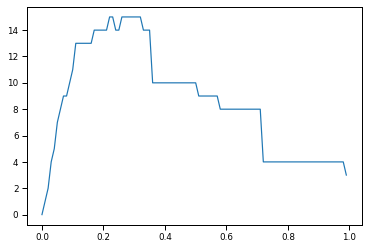

In [30]:
def show_points(arr):
    plt.plot(*zip(*arr))
    

item = 3818
    
arr = flips_by_pctiles(item, .15)
show_points(arr)

In [33]:
best_flip_pctile_at_fixed_profit(item, .15)

(0.22, 15)

In [34]:
arr = flip_by_profit_at_best_pctile(item)

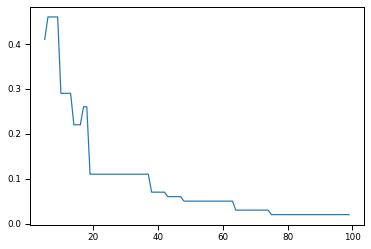

In [36]:
show_points([(i[0], i[1][0]) for i in arr])

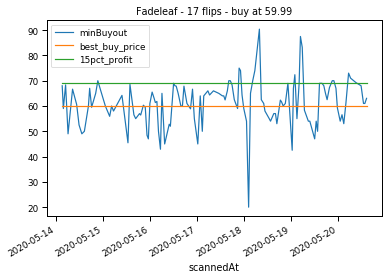

In [5]:
def find_optimal_flip(item, show_plot=False):
    flip_profile =  num_flips_over_all_pctiles(item)
    best_pctile, best_num_flips = max(flip_profile, key=lambda x:x[1])
    best_buy_price = get_minBuyout_at_pctile(item, best_pctile)
    
    if show_plot:
        df = db.get_df(item)
        df['best_buy_price'] = best_buy_price
        df['15pct_profit'] = best_buy_price * 1.15
        graph_title = f'{db.get_name(item)} - {best_num_flips} flips - buy at {round(best_buy_price,2)}'
        df.plot('scannedAt', ['minBuyout', 'best_buy_price', '15pct_profit'], title=graph_title)
    
    # return export ready data if not in plot mode
    else:
        return {
            'name'        : db.get_name(item),
            'item_id'     : item,
            'buy_price'   : int(100 * best_buy_price),         # scaling copper back into integer for export
            'min_price'   : int(100 * best_buy_price * 1.15),  # scaling copper back into integer for export
            'normal_price': int(100 * best_buy_price * 1.25),  # scaling copper back into integer for export
            'max_price'   : int(100 * best_buy_price * 1.5),   # scaling copper back into integer for export
            'num_flips'   : best_num_flips,
            'avg_quantity': int(db.get_df(item)['quantity'].mean())
        }

find_optimal_flip(3818, show_plot=True)        

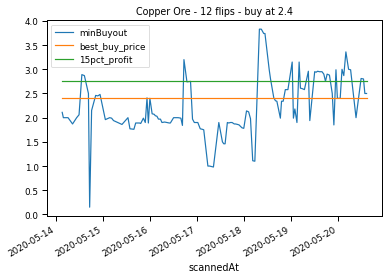

In [6]:
find_optimal_flip(2770, show_plot=True)

In [7]:
find_optimal_flip(2770, show_plot=False)

{'name': 'Copper Ore',
 'item_id': 2770,
 'buy_price': 240,
 'min_price': 276,
 'normal_price': 300,
 'max_price': 360,
 'num_flips': 12,
 'avg_quantity': 524}

### Run All Materials

In [8]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  ALL         : 213 items



In [9]:
def run_analysis(list_of_items):
    results = []
    print(f'running for {len(list_of_items)} items')
    for i in range(0, len(list_of_items)):
        item = list_of_items[i]
        
        # catch no data errors with try/except
        try:
            results.append(find_optimal_flip(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')

        # print progress
        if i%10 ==0:
            print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results)

df = run_analysis(ALL)    

running for 213 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
 ...190 done
 ...200 done
 ...210 done
COMPLETE


In [11]:
df

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity,restock
0,Wildvine,8153,13876,15957,17345,20814,12,144,30
1,Arthas' Tears,8836,399,458,498,598,9,135,30
2,Black Lotus,13468,1564018,1798621,1955023,2346027,1,17,30
3,Plaguebloom,13466,18770,21585,23462,28155,8,231,30
4,Mountain Silversage,13465,11985,13783,14982,17978,9,227,30
...,...,...,...,...,...,...,...,...,...
200,Small Blue Pouch,828,875,1006,1093,1312,7,2,1
201,Blue Leather Bag,856,1600,1839,2000,2400,2,2,1
202,Large Red Sack,857,5000,5750,6250,7500,5,3,1
203,Fel Steed Saddlebags,932,10000,11500,12500,15000,0,1,1


### Export

In [12]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [29]:
def set_restock_value(item):
    if item in herbs + skinning:
        return 40
    if item in cloth + mining:
        return 60
    if item in bags:
        return 1
    return 30

df['restock'] = df['item_id'].apply(set_restock_value)

In [30]:
choice = df.query('num_flips >=7 and min_price>200').sort_values(by='num_flips')
choice

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity,restock
200,Small Blue Pouch,828,875,1006,1093,1312,7,2,1
41,Bolt of Runecloth,14048,4704,5410,5880,7057,7,67,60
18,Gromsblood,8846,4312,4959,5390,6468,7,629,40
60,Truesilver Bar,6037,1724,1983,2155,2586,7,78,60
69,Vision Dust,11137,397,457,497,596,7,314,30
...,...,...,...,...,...,...,...,...,...
23,Swiftthistle,2452,6400,7359,8000,9600,15,295,40
13,Khadgar's Whisker,3358,1125,1293,1406,1687,16,178,40
55,Silver Bar,2842,732,841,915,1098,16,80,60
17,Fadeleaf,3818,5999,6898,7498,8998,17,145,40


In [31]:
EXPORT(choice)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SSmall Blue Pouch^T^SaboveMax^SmaxPrice^SnormalPrice^S1093^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S1312^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S1006^SkeepQtySources^T^t^Sblacklist^S^t^SBolt of Runecloth^T^SaboveMax^SmaxPrice^SnormalPrice^S5880^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S7057^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S5410^SkeepQtySources^T^t^Sblacklist^S^t^SGromsblood^T^SaboveMax^SmaxPrice^SnormalPrice^S5390^Sduration^N3^SmatchSt

In [32]:
other = enchant+bags
other = df.query('item_id in @other')
other

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips,avg_quantity,restock
67,Strange Dust,10940,176,202,220,264,14,443,30
68,Soul Dust,11083,1000,1150,1250,1500,9,129,30
69,Vision Dust,11137,397,457,497,596,7,314,30
70,Dream Dust,11176,2726,3134,3407,4089,13,190,30
71,Illusion Dust,16204,1261,1450,1577,1892,9,1333,30
...,...,...,...,...,...,...,...,...,...
200,Small Blue Pouch,828,875,1006,1093,1312,7,2,1
201,Blue Leather Bag,856,1600,1839,2000,2400,2,2,1
202,Large Red Sack,857,5000,5750,6250,7500,5,3,1
203,Fel Steed Saddlebags,932,10000,11500,12500,15000,0,1,1


In [33]:
EXPORT(other)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SStrange Dust^T^SaboveMax^SmaxPrice^SnormalPrice^S220^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S264^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S202^SkeepQtySources^T^t^Sblacklist^S^t^SSoul Dust^T^SaboveMax^SmaxPrice^SnormalPrice^S1250^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S1500^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S1150^SkeepQtySources^T^t^Sblacklist^S^t^SVision Dust^T^SaboveMax^SmaxPrice^SnormalPrice^S497^Sduration^N3^SmatchStackSize^b^Skeep

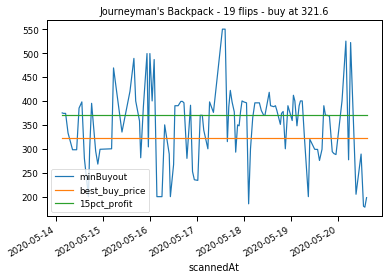

In [27]:
find_optimal_flip(3914, show_plot=True)

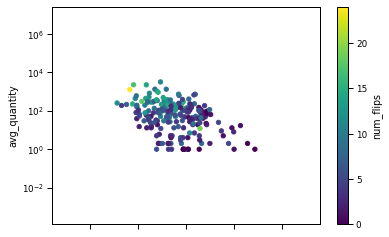

In [24]:
df.plot.scatter(x='min_price', y='avg_quantity', c='num_flips', colormap='viridis', logy=True, logx=True)